<a href="https://colab.research.google.com/github/m7mdrf3t/CartFarahAR/blob/main/smileDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q \
    numpy==1.21 torch==1.4.0 torchvision==0.5.0 \
    tqdm==4.43.0 pillow==7.0.0 matplotlib==3.2.0 \
    pandas==1.1 \

    

# New section

In [ ]:
import math
import random
import shutil
from datetime import datetime
from pathlib import Path
from urllib.request import urlretrieve

import PIL.Image as Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from IPython.display import clear_output, display, HTML
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm

pd.options.display.precision = 3
pd.options.display.max_rows = 10

In [ ]:
torch.__version__


'1.4.0'

In [ ]:
RANDOM_SEED = 123

random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Flip values for slower training speed, but more determenistic results.
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
MAIN_ATTRIBUTE = 'Smiling'                                  # Name of the class we will predict
IMAGE_SIZE = 64                # Size of the model's input

In [ ]:
WORKING_DIR_PATH = Path('.')                                   # Base directory for all the content

IMAGES_ZIP_PATH = WORKING_DIR_PATH / 'img_align_celeba.zip'    # Archive with images
IMAGES_DIR_PATH = IMAGES_ZIP_PATH.with_suffix('')              # Directory with images
ANNOTATIONS_PATH = WORKING_DIR_PATH / 'list_attr_celeba.txt'   # Text document with labels for every image.
PARTITION_PATH = WORKING_DIR_PATH / 'list_eval_partition.txt'  # Text document with marks what subset
                                                               # (train, validation or split) an image belongs to.

CHECKPOINTS_PATH = WORKING_DIR_PATH / 'checkpoints'            # Path to the weights of the trained model
ONNX_PATH = WORKING_DIR_PATH / 'classifier.onnx'

CHECKPOINTS_PATH.mkdir(exist_ok=True)

CELEBA_FACE_SIZE = 178

In [ ]:
BATCH_SIZE = 128               # Batch size
EPOCHS = 20                    # Number of epochs of training

LR = 1e-2                      # Learning rate
LR_DECAY_STEP = 7              # Number of epochs after that we will decrease the learning rate
LR_DECAY_GAMMA = 0.1           # Decaying coefficient
WEIGHT_DECAY = 1e-4            # Weight decay coefficient

CONSISTENCY_WEIGHT = 0.1       # Coefficient for the consistency part of the loss function

NUM_WORKERS = 4                # Number of parallel processes for loading images

In [ ]:
def copy_files_from_drive():
    DRIVE_PATH = WORKING_DIR_PATH / 'drive' / 'My Drive'  # The mounted Google Drive
    from google.colab import drive
    drive.mount(str(DRIVE_PATH.parent))
    
    shutil.copy(DRIVE_PATH /'CelebA'/ 'Img'/ IMAGES_ZIP_PATH.name, IMAGES_ZIP_PATH)
    shutil.copy(DRIVE_PATH /'CelebA'/ 'Anno' /ANNOTATIONS_PATH.name, ANNOTATIONS_PATH)
    shutil.copy(DRIVE_PATH /'CelebA'/ 'Eval'/ PARTITION_PATH.name, PARTITION_PATH)


## Uncomment for copying files to Colab
copy_files_from_drive()

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
if not IMAGES_DIR_PATH.exists():
    shutil.unpack_archive(str(IMAGES_ZIP_PATH), str(WORKING_DIR_PATH))

In [ ]:
df_attr = pd.read_csv(ANNOTATIONS_PATH, sep='\s+', skiprows=1, index_col=0)

In [ ]:
df_attr

AttributeError: ignored

            5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
000001.jpg                -1                1           1               -1   
000002.jpg                -1               -1          -1                1   
000003.jpg                -1               -1          -1               -1   
000004.jpg                -1               -1           1               -1   
000005.jpg                -1                1           1               -1   
...                      ...              ...         ...              ...   
202595.jpg                -1               -1           1               -1   
202596.jpg                -1               -1          -1               -1   
202597.jpg                -1               -1          -1               -1   
202598.jpg                -1                1           1               -1   
202599.jpg                -1                1           1               -1   

            Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_

In [ ]:
df_attr = df_attr[[MAIN_ATTRIBUTE]].replace({-1: 0})

In [ ]:
df_attr

AttributeError: ignored

            Smiling
000001.jpg        1
000002.jpg        1
000003.jpg        0
000004.jpg        0
000005.jpg        0
...             ...
202595.jpg        0
202596.jpg        1
202597.jpg        1
202598.jpg        1
202599.jpg        0

[202599 rows x 1 columns]

In [ ]:
samples_with_glasses = list(df_attr[df_attr[MAIN_ATTRIBUTE] == 1].sample(25, random_state=RANDOM_SEED).index)
samples_without_glasses = list(df_attr[df_attr[MAIN_ATTRIBUTE] == 0].sample(25, random_state=RANDOM_SEED).index)

In [ ]:
def load_and_show(image_names, titles=None, directory=IMAGES_DIR_PATH):
    if titles is None:
        titles = image_names
    N = len(image_names)
    cols = int(math.sqrt(N))
    rows = int(math.ceil(N / cols))
    plt.figure(figsize=(12, 12))
    image_names_iter = iter(image_names)
    titles_iter = iter(titles)
    for r in range(rows):
        for c in range(cols):
            try:
                name = next(image_names_iter)
                title = next(titles_iter)
            except StopIteration:
                plt.show()
                return
            plt.subplot(rows, cols, cols * r + c + 1)
            with Image.open(Path(directory) / name) as image_pil:
                image = np.array(image_pil.convert('RGB'))
            plt.imshow(image)
            plt.axis('off')
            plt.title(title)

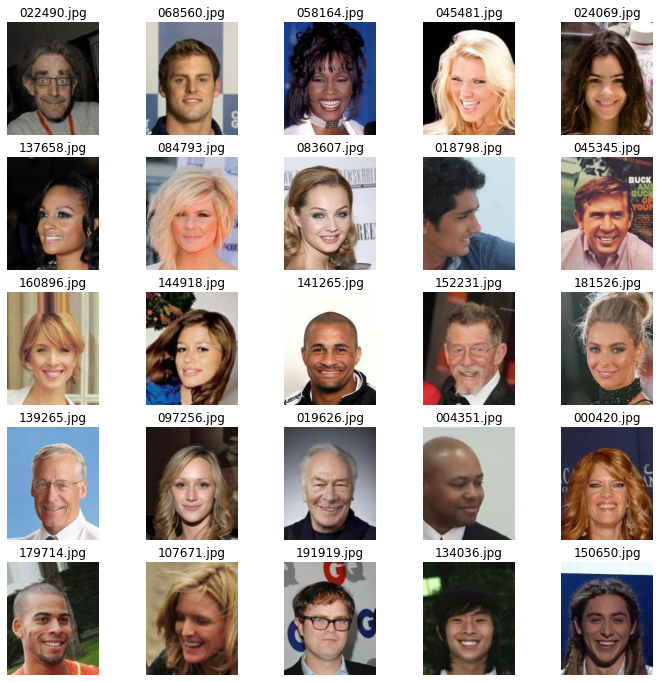

In [ ]:
load_and_show(samples_with_glasses)

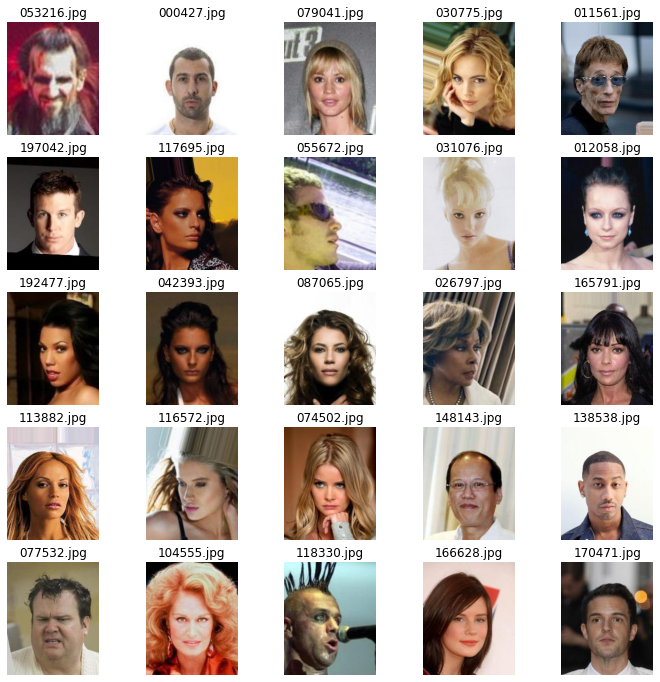

In [ ]:
load_and_show(samples_without_glasses)

In [ ]:
ratio = df_attr[MAIN_ATTRIBUTE].mean()
print(f'{MAIN_ATTRIBUTE}: {ratio * 100:0.2f} %')

Smiling: 48.21 %


In [ ]:
df_partition = pd.read_csv(PARTITION_PATH, sep='\s+', names=['fold'], index_col=0)
df_partition.fold.value_counts()

0    162770
2     19962
1     19867
Name: fold, dtype: int64

In [ ]:
df_attr = df_attr.join(df_partition)

In [ ]:
df_train = df_attr[df_attr.fold == 0]
df_valid = df_attr[df_attr.fold != 0]

In [ ]:
def equalize(df, attribute):
    N = len(df)
    ones = df[attribute].sum()
    k = min(ones, N - ones)
    df_ones = df[df[attribute] == 1].sample(k)
    df_zeros = df[df[attribute] == 0].sample(k)
    index = list(df_ones.index) + list(df_zeros.index)
    random.shuffle(index)
    return df.loc[index]

In [ ]:
df_train = equalize(df_train, MAIN_ATTRIBUTE)
df_valid = equalize(df_valid, MAIN_ATTRIBUTE)

In [ ]:
crop_resize = transforms.Compose([
    transforms.CenterCrop(CELEBA_FACE_SIZE),
    transforms.Resize(IMAGE_SIZE),
])

transforms_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.2, hue=0.1),
    transforms.RandomAffine(3, scale=(0.95, 1.05)),
    transforms.ToTensor(),
])

transforms_valid = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
def load_images(df):
    images = []
    for image_name in tqdm(df.index, dynamic_ncols=True, leave=False):
        image_pil = Image.open(IMAGES_DIR_PATH / image_name)
        image = crop_resize(image_pil)
        images.append(image)
    return images

In [ ]:
images_train = load_images(df_train)
images_valid = load_images(df_valid)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
class CelebaDataset(data.Dataset):
    def __init__(self, df, images, transforms=None):
        self.df = df
        self.images = images
        self.transforms = transforms

    def __getitem__(self, index):
        row = self.df.iloc[index]
        image_name = row.name
        attrs = row[MAIN_ATTRIBUTE]
        image = self.images[index]
        image_tensor = self.transforms(image)
        return image_tensor, attrs

    def __len__(self):
        return len(self.df)

In [ ]:
def decode(tensor):
    return (tensor.cpu()
                  .clamp(0, 1)
                  .numpy()
                  .transpose((1, 2, 0)))

In [ ]:
dataset_train = CelebaDataset(df_train, images_train, transforms_train)
dataset_valid = CelebaDataset(df_valid, images_valid, transforms_valid)

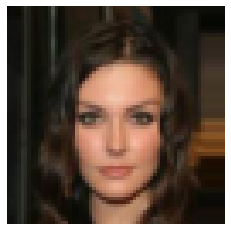

In [ ]:
image, attrs = next(iter(dataset_valid))

plt.imshow(decode(image))
plt.axis('off')
plt.show()

In [ ]:
def get_weights(arr):
    N = len(arr)
    ones = arr.sum()
    zeros = N - ones
    return (1 - arr) + arr * zeros / ones 

In [ ]:
weights_train = get_weights(df_train[MAIN_ATTRIBUTE].values)
weights_valid = get_weights(df_valid[MAIN_ATTRIBUTE].values)

In [ ]:
loader_train = data.DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    sampler=data.WeightedRandomSampler(weights_train, len(df_train)),
    num_workers=NUM_WORKERS,
    drop_last=True)
loader_valid = data.DataLoader(
    dataset_valid,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    drop_last=False)

In [ ]:
class SeparableConvBN(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Conv2d(channels_in, channels_in,
                      kernel_size=3, padding=1,
                      groups=channels_in, bias=False),
            nn.BatchNorm2d(channels_in),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels_in, channels_out,
                      kernel_size=1, padding=0,
                      bias=False),
            nn.BatchNorm2d(channels_out),
        )

    def forward(self, x):
        return self.blocks(x)

In [ ]:
class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        
        a = np.array([1., 2., 1.], dtype=np.float32)
        a2 = a[:,None] * a[None,:]
        filt = torch.tensor(a2 / a2.sum())[None,None,:,:].repeat((channels,1,1,1))
        self.register_buffer('filt', filt)
        self.pad = nn.ReflectionPad2d([1, 1, 1, 1])
        self.channels = channels

    def forward(self, x):
        return F.conv2d(self.pad(x), self.filt, stride=2, groups=self.channels)

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        blocks = []

        blocks.extend([ 
            # 64x64
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            Downsample(16),

            # 32x32
            SeparableConvBN(16, 32),
            nn.ReLU(inplace=True),
            Downsample(32),
            
            # 16x16
            SeparableConvBN(32, 32),
            nn.ReLU(inplace=True),
            Downsample(32),

            # 8x8
            SeparableConvBN(32, 32),
            nn.ReLU(inplace=True),
            Downsample(32),
            
            # 4x4
            SeparableConvBN(32, 64),
            nn.ReLU(inplace=True),
            Downsample(64),
            
            nn.AdaptiveAvgPool2d(1),

            nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0),
            nn.Flatten(1),
        ])

        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        return self.blocks(x)

In [ ]:
model = Classifier()

In [ ]:
bce = nn.BCEWithLogitsLoss()
mse = nn.MSELoss()

In [ ]:
model = model.to(device)

In [ ]:
def f1_score(conf_mat):
    tp = conf_mat[1, 1]
    fp = conf_mat[1, 0]
    fn = conf_mat[0, 1]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1

In [ ]:
def valid(loader=loader_valid):
    model.eval()
    confusion_matrix = np.zeros((2, 2), dtype=int)
    loss = 0
    pbar = tqdm(enumerate(loader), total=len(loader), dynamic_ncols=True, leave=False, desc='Validating')
    for i, (images, attrs) in pbar:
        images = images.to(device)
        with torch.no_grad():
            outputs = model(images)
            loss += bce(outputs, attrs.unsqueeze(1).to(device).float()).cpu().item()
        outputs = outputs.squeeze(1)
        preds = (outputs.cpu() > 0).int()
        for y_pred, y_true in zip(preds, attrs):
            confusion_matrix[y_true.item()][y_pred.item()] += 1
        precision, recall, f1 = f1_score(confusion_matrix)
        pbar.set_postfix({
            'Lclass': f'{loss / (i + 1):0.2f}',
            'F1': f'{f1:0.2f}',
            'Precision': f'{precision:0.2f}',
            'Recall': f'{recall:0.2f}',
        }, refresh=False)
    return loss / len(loader), precision, recall, f1, confusion_matrix

In [ ]:
loss, precision, recall, f1, confusion_matrix = valid()
print(f'Loss: {loss:.3f}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


Loss: 0.693


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=LR_DECAY_STEP, gamma=LR_DECAY_GAMMA)

In [ ]:
def random_change(images):
    pad = nn.ReflectionPad2d(1)
    images_padded = pad(images)
    outputs = []
    for i in range(images.size(0)):
        dx = random.randint(-1, 1)
        dy = random.randint(-1, 1)
        if dx == 0 and dy == 0:
            outputs.append(torch.flip(images[[i]], [-1]))
        else:
            h, w = image.shape[-2:]
            outputs.append(images_padded[[i], :, 1+dy:h+dy+1, 1+dx:w+dx+1])
    return torch.cat(outputs, 0)

In [ ]:
def ema(new, old, alpha=0.6):
    if old is None or math.isnan(old):
        return new
    return alpha * new + (1 - alpha) * old

In [ ]:
column_names = [
    'L_class_valid', 'L_class', 
    'L_cons', 'L_total',
    'Precision', 'Recall', 'F1',
    'LR'
]
# stats = pd.DataFrame(columns=['Epoch', *column_names]).set_index('Epoch')
best_checkpoint = None

for epoch in range(EPOCHS):    
    metrics = pd.Series(index=column_names, dtype=float, name=epoch)
    
    model.train()
    pbar = tqdm(enumerate(loader_train), total=len(loader_train),
                dynamic_ncols=True, leave=False, desc='Training')
    for i, (images, attrs) in pbar:
        images = images.to(device)
        attrs = attrs.to(device).float().unsqueeze(1)

        outputs = model(images)
        outputs_changed = model(random_change(images))
        
        loss_classification = bce(outputs, attrs)
        loss_consistency = mse(outputs, outputs_changed)
        loss_total = loss_classification + CONSISTENCY_WEIGHT * loss_consistency

        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()

        metrics.L_class = ema(loss_classification.item(), metrics.L_class)
        metrics.L_cons = ema(loss_consistency.item(), metrics.L_cons)
        metrics.L_total = ema(loss_total, metrics.L_total)
        
        lr = scheduler.get_last_lr()[0]
        pbar.set_postfix({
            'Lclass': f'{loss_classification.item():.3f}',
            'Lcons': f'{loss_consistency.item():.3f}',
            'LR': f'{lr:.0e}'
        }, refresh=False)

    loss_valid, precision, recall, f1, confusion_matrix = valid()
    scheduler.step()

    if best_checkpoint is None:
        current_time = datetime.now().isoformat()
        best_checkpoint = CHECKPOINTS_PATH / f'classifier-{epoch}-{f1:0.2f}.pth'
        torch.save(model.state_dict(), best_checkpoint)
    
    metrics.L_class_valid = loss_valid
    metrics.F1 = f1
    metrics.Precision = precision
    metrics.Recall = recall
    metrics.LR = lr
    # stats = stats.append(metrics)
    
    clear_output(wait=True)
    # display(HTML(stats.to_html()))

model.load_state_dict(torch.load(best_checkpoint))
model.eval()

print('Best checkpoint:', best_checkpoint)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app
